### Imports

In [160]:
# Import libraries needed for webscraping
import requests
from datetime import datetime
import time
import random
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import regex as re
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize, RegexpTokenizer

from bs4 import BeautifulSoup    

import unidecode
import contractions
import redditcleaner
import spacy
#spacy.cli.download('en_core_web_md')
#spacy.cli.download('en_core_web_sm')

pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 500)

### Load Data

In [161]:
df = pd.read_csv('../data/df_cleaned_ab.csv')

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subreddit     10 non-null     int64 
 1   text_cleaned  10 non-null     object
dtypes: int64(1), object(1)
memory usage: 288.0+ bytes


In [163]:
# fillter data with value = NaN
bool_series = pd.isnull(df["text_cleaned"])

In [164]:
# Nan value due to the text cleaning that returned no words
df[bool_series]

,subreddit,text_cleaned


In [165]:
# drop
df.dropna(axis = 0, inplace = True)

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subreddit     10 non-null     int64 
 1   text_cleaned  10 non-null     object
dtypes: int64(1), object(1)
memory usage: 288.0+ bytes


In [8]:
df.drop(columns = ['title', 'author'], inplace = True)

In [10]:
# Save to csv
df.to_csv("../data/df_cleaned_ab.csv", index=False)

In [152]:
df = pd.read_csv('../data/df_cleaned_ab.csv')

### Baseline accuracy

In [167]:
#assign target and result to y and X then carry out train test split
y = df['subreddit']
X = df['text_cleaned']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, stratify=y, random_state=123)

In [168]:
X_train.shape, X_test.shape

((7,), (3,))

In [169]:
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

In [170]:
from sklearn import set_config

In [171]:
set_config(transform_output='pandas')

In [172]:
# adopted from class
# Instantiate a CountVectorizer.
cvec = CountVectorizer()

# Fit the vectorizer on our corpus.
cvec.fit(X_train)

# Transform the corpus.
X_train = cvec.transform(X_train)

X_test = cvec.transform(X_test)

In [173]:
# Convert X_train into a DataFrame.
# We will not actually use this for modeling,
# this is just to visualize what is happening
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names_out())

In [20]:
import sys

In [21]:
sys.getsizeof(X_train)

48

In [22]:
sys.getsizeof(X_train.todense())

152

In [23]:
sys.getsizeof(X_train_df)

629021328

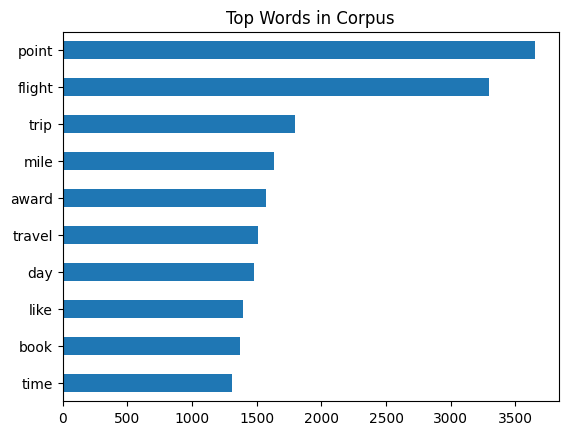

In [24]:
X_train_df.sum().sort_values().tail(10).plot(kind='barh')
plt.title('Top Words in Corpus');

In [25]:
train_df=X_train_df.copy()
train_df['subreddit']=y_train.values

In [26]:
check = X_train_df[y_train.reset_index(drop=True)==0]

In [27]:
check.sum().sort_values()/len(check)

lighterpack    0.000000
posible        0.000000
warmer         0.000000
warmth         0.000000
posing         0.000000
                 ...   
book           0.448802
mile           0.532107
award          0.545644
flight         1.083652
point          1.235335
Length: 13882, dtype: float64

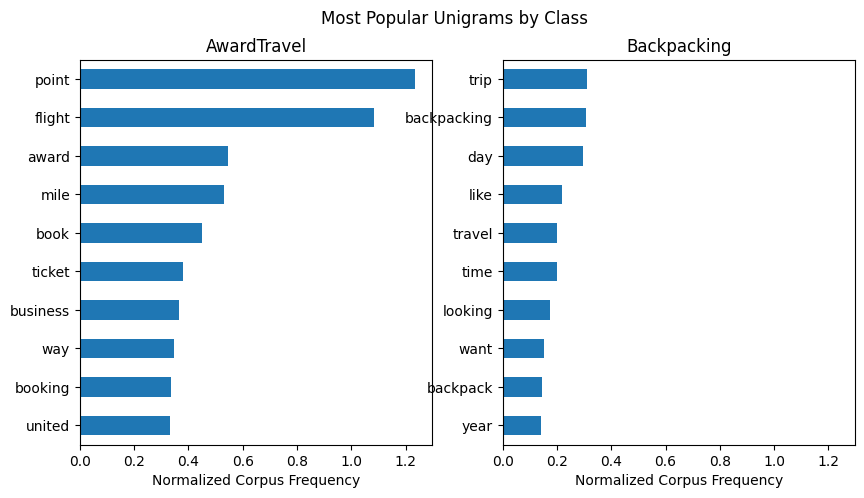

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharex=True)

for i in range(2):
    trsvelhack = X_train_df[y_train.reset_index(drop=True)==i]
    (trsvelhack.sum().sort_values()/len(trsvelhack)).tail(10).plot(kind='barh', ax=axs[i])
    axs[i].set_title(['AwardTravel', 'Backpacking'][i])
    axs[i].set_xlabel('Normalized Corpus Frequency')
    
plt.suptitle('Most Popular Unigrams by Class');

In [184]:
X_train.shape

(7, 127)

In [185]:
#assign target and result to y and X then carry out train test split
y = df['subreddit']
X = df['text_cleaned']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, stratify=y, random_state=123)

In [186]:
# adopted from class
# Instantiate a CountVectorizer.
tvec = TfidfVectorizer()

# Fit the vectorizer on our corpus.
tvec.fit(X_train)

# Transform the corpus.
X_train_tvec = tvec.transform(X_train)

X_test_tvec = tvec.transform(X_test)

In [175]:
# Convert X_train into a DataFrame.
# We will not actually use this for modeling,
# this is just to visualize what is happening
X_train_df_tvec = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names_out())

AttributeError: lower not found

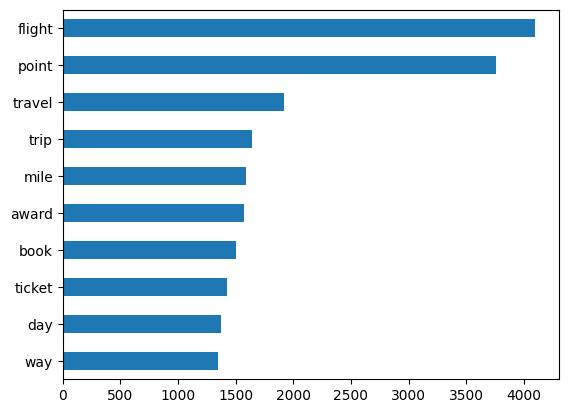

In [404]:
# plot top occuring words
#X_train_df_tvec.sum().sort_values().tail(10).plot(kind='barh');

### Modeling

In [32]:
#assign target and result to y and X then carry out train test split
y = df['subreddit']
X = df['text_cleaned']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, stratify=y, random_state=123)

#### Model 1: CountVectorizer and LogisticRegression

In [33]:
# set a pipeline up with two stages: CountVectorizer (transformer) and LogisticRegression (estimator)
pipe_log = Pipeline([('cvec', CountVectorizer()),
                 ('log', LogisticRegression())
                ])

In [34]:
# fit
pipe_log.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('log', LogisticRegression())])

In [35]:
cross_val_score(pipe_log, X_train, y_train, cv=5)

array([0.97087379, 0.96910856, 0.96293027, 0.96293027, 0.97084806])

In [36]:
print(f"Training Score: {pipe_log.score(X_train, y_train)}")
print(f"Testing Score: {pipe_log.score(X_test, y_test)}")
print(f"Cross Val Score: {cross_val_score(pipe_log, X_train, y_train, cv=5).mean()}")

Training Score: 0.993114406779661
Testing Score: 0.9703389830508474
Cross Val Score: 0.9673381903012421


In [37]:
# check the adjustable parameters
pipe_log.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cvec', 'log', 'cvec__analyzer', 'cvec__binary', 'cvec__decode_error', 'cvec__dtype', 'cvec__encoding', 'cvec__input', 'cvec__lowercase', 'cvec__max_df', 'cvec__max_features', 'cvec__min_df', 'cvec__ngram_range', 'cvec__preprocessor', 'cvec__stop_words', 'cvec__strip_accents', 'cvec__token_pattern', 'cvec__tokenizer', 'cvec__vocabulary', 'log__C', 'log__class_weight', 'log__dual', 'log__fit_intercept', 'log__intercept_scaling', 'log__l1_ratio', 'log__max_iter', 'log__multi_class', 'log__n_jobs', 'log__penalty', 'log__random_state', 'log__solver', 'log__tol', 'log__verbose', 'log__warm_start'])

In [38]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000
# Minimum number of documents needed to include token: 1, 2, 3
# Maximum number of documents needed to include token: 40%, 50%, 60%, 70%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [.4, .5, .6, .7],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words' : ['english', None]
}

In [40]:
# Instantiate GridSearchCV.
gs = GridSearchCV(pipe_log,
                  pipe_params,
                  cv=5)

In [41]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('log', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.4, 0.5, 0.6, 0.7],
                         'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english', None]})

In [42]:
gs.best_params_

{'cvec__max_df': 0.4,
 'cvec__max_features': 4000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [43]:
gs.best_score_

0.967338034362632

In [44]:
print(f"Training Score: {gs.score(X_train, y_train)}")
print(f"Testing Score: {gs.score(X_test, y_test)}")
print(f"Best Score: {gs.best_score_}")

Training Score: 0.9920550847457628
Testing Score: 0.96875
Best Score: 0.967338034362632


In [45]:
# fit in the best model
best_rf = gs.best_estimator_
best_rf.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.4, max_features=4000, min_df=3)),
                ('log', LogisticRegression())])

In [46]:
print(best_rf.score(X_train, y_train))
print(best_rf.score(X_test, y_test))

0.9920550847457628
0.96875


#### Model 2: CountVectorizer and MultinomialNB

In [47]:
# set a pipeline up with two stages: CountVectorizer (transformer) and MultinomialNB (estimator)
pipe_nb = Pipeline([('cvec', CountVectorizer()),
                 ('nb', MultinomialNB())
                ])

In [48]:
# fit
pipe_nb.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])

In [49]:
cross_val_score(pipe_nb, X_train, y_train, cv=5)

array([0.96557811, 0.96557811, 0.97087379, 0.96381289, 0.96378092])

In [50]:
print(f"Training Score: {pipe_nb.score(X_train, y_train)}")
print(f"Testing Score: {pipe_nb.score(X_test, y_test)}")
print(f"Cross Val Score: {cross_val_score(pipe_nb, X_train, y_train, cv=5).mean()}")

Training Score: 0.9809322033898306
Testing Score: 0.9602754237288136
Cross Val Score: 0.9659247627394049


In [51]:
# check the adjustable parameters
pipe_nb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cvec', 'nb', 'cvec__analyzer', 'cvec__binary', 'cvec__decode_error', 'cvec__dtype', 'cvec__encoding', 'cvec__input', 'cvec__lowercase', 'cvec__max_df', 'cvec__max_features', 'cvec__min_df', 'cvec__ngram_range', 'cvec__preprocessor', 'cvec__stop_words', 'cvec__strip_accents', 'cvec__token_pattern', 'cvec__tokenizer', 'cvec__vocabulary', 'nb__alpha', 'nb__class_prior', 'nb__fit_prior', 'nb__force_alpha'])

In [52]:
pipe_params_2 = {
    'cvec__max_features': [1000, 2000, 3000, 4000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [.5, .6, .7, .8],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words' : ['english', None]
}

In [53]:
gs_2 = GridSearchCV(pipe_nb,
                  pipe_params_2,
                  cv=5)

In [54]:
gs_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.5, 0.6, 0.7, 0.8],
                         'cvec__max_features': [1000, 2000, 3000, 4000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english', None]})

In [55]:
gs_2.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 4000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [56]:
gs_2.best_score_

0.9593910909153284

In [57]:
print(f"Training Score: {gs_2.score(X_train, y_train)}")
print(f"Testing Score: {gs_2.score(X_test, y_test)}")
print(f"Best Score: {gs_2.best_score_}")

Training Score: 0.9661016949152542
Testing Score: 0.9555084745762712
Best Score: 0.9593910909153284


In [58]:
# fit in the best model
best_rf_2 = gs_2.best_estimator_
best_rf_2.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.5, max_features=4000, min_df=3)),
                ('nb', MultinomialNB())])

In [59]:
print(best_rf_2.score(X_train, y_train))
print(best_rf_2.score(X_test, y_test))

0.9661016949152542
0.9555084745762712


#### III. Model 3: TfidfVectorizer and Logistic Regression

In [60]:
pipe_tvec_log = Pipeline([('tvec', TfidfVectorizer()),
                 ('log', LogisticRegression())
                ])

In [61]:
pipe_tvec_log.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer()), ('log', LogisticRegression())])

In [62]:
cross_val_score(pipe_tvec_log, X_train, y_train, cv=5)

array([0.97087379, 0.9717564 , 0.96557811, 0.96646072, 0.9655477 ])

In [63]:
print(f"Training Score: {pipe_tvec_log.score(X_train, y_train)}")
print(f"Testing Score: {pipe_tvec_log.score(X_test, y_test)}")
print(f"Cross Val Score: {cross_val_score(pipe_tvec_log, X_train, y_train, cv=5).mean()}")

Training Score: 0.981638418079096
Testing Score: 0.9645127118644068
Cross Val Score: 0.9680433446960599


In [64]:
# check the adjustable parameters
pipe_tvec_log.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tvec', 'log', 'tvec__analyzer', 'tvec__binary', 'tvec__decode_error', 'tvec__dtype', 'tvec__encoding', 'tvec__input', 'tvec__lowercase', 'tvec__max_df', 'tvec__max_features', 'tvec__min_df', 'tvec__ngram_range', 'tvec__norm', 'tvec__preprocessor', 'tvec__smooth_idf', 'tvec__stop_words', 'tvec__strip_accents', 'tvec__sublinear_tf', 'tvec__token_pattern', 'tvec__tokenizer', 'tvec__use_idf', 'tvec__vocabulary', 'log__C', 'log__class_weight', 'log__dual', 'log__fit_intercept', 'log__intercept_scaling', 'log__l1_ratio', 'log__max_iter', 'log__multi_class', 'log__n_jobs', 'log__penalty', 'log__random_state', 'log__solver', 'log__tol', 'log__verbose', 'log__warm_start'])

In [65]:
pipe_params_3 = {
    'log__C': [0.01, 0.1, 1, 10, 100],
    'log__penalty': ['l1', 'l2'],
    'log__solver': ['lbfgs', 'saga'],
    'tvec__max_features': [2000, 4000, 6000],
    'tvec__ngram_range': [(1, 1), (1, 2)]}

In [66]:
gs_3 = GridSearchCV(pipe_tvec_log,
                  pipe_params_3,
                  cv=5, verbose = 2, n_jobs = -1)

In [67]:
gs_3.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


C:\Users\skyne\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalt

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('log', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'log__C': [0.01, 0.1, 1, 10, 100],
                         'log__penalty': ['l1', 'l2'],
                         'log__solver': ['lbfgs', 'saga'],
                         'tvec__max_features': [2000, 4000, 6000],
                         'tvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=2)

In [68]:
gs_3.best_params_

{'log__C': 10,
 'log__penalty': 'l2',
 'log__solver': 'saga',
 'tvec__max_features': 6000,
 'tvec__ngram_range': (1, 2)}

In [69]:
gs_3.best_score_

0.9768707175359204

In [70]:
print(f"Training Score: {gs_3.score(X_train, y_train)}")
print(f"Testing Score: {gs_3.score(X_test, y_test)}")
print(f"Best Score: {gs_3.best_score_}")

Training Score: 0.9971751412429378
Testing Score: 0.975635593220339
Best Score: 0.9768707175359204


In [71]:
# fit in the best model
best_rf_3 = gs_3.best_estimator_
best_rf_3.fit(X_train, y_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=6000, ngram_range=(1, 2))),
                ('log', LogisticRegression(C=10, solver='saga'))])

In [72]:
print(best_rf_3.score(X_train, y_train))
print(best_rf_3.score(X_test, y_test))

0.9971751412429378
0.975635593220339


#### Model 4: TfidfVectorizer and MultinomialNB

In [73]:
pipe_tvec_nb = Pipeline([('tvec', TfidfVectorizer()),
                 ('nb', MultinomialNB())
                ])

In [74]:
pipe_tvec_nb.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer()), ('nb', MultinomialNB())])

In [75]:
cross_val_score(pipe_tvec_nb, X_train, y_train, cv=5)

array([0.95233892, 0.95851721, 0.96557811, 0.95675199, 0.94611307])

In [76]:
print(f"Training Score: {pipe_tvec_nb.score(X_train, y_train)}")
print(f"Testing Score: {pipe_tvec_nb.score(X_test, y_test)}")
print(f"Cross Val Score: {cross_val_score(pipe_tvec_nb, X_train, y_train, cv=5).mean()}")

Training Score: 0.9821680790960452
Testing Score: 0.9533898305084746
Cross Val Score: 0.9558598610898861


In [77]:
# check the adjustable parameters
pipe_tvec_nb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tvec', 'nb', 'tvec__analyzer', 'tvec__binary', 'tvec__decode_error', 'tvec__dtype', 'tvec__encoding', 'tvec__input', 'tvec__lowercase', 'tvec__max_df', 'tvec__max_features', 'tvec__min_df', 'tvec__ngram_range', 'tvec__norm', 'tvec__preprocessor', 'tvec__smooth_idf', 'tvec__stop_words', 'tvec__strip_accents', 'tvec__sublinear_tf', 'tvec__token_pattern', 'tvec__tokenizer', 'tvec__use_idf', 'tvec__vocabulary', 'nb__alpha', 'nb__class_prior', 'nb__fit_prior', 'nb__force_alpha'])

In [78]:
pipe_params_4 = {
    'tvec__max_features': [2000, 4000, 6000],
    'tvec__ngram_range': [(1, 1), (1, 2)]}

In [79]:
gs_4 = GridSearchCV(pipe_tvec_nb,
                  pipe_params_4,
                  cv=5, verbose = 2, n_jobs = -1)

In [80]:
gs_4.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__max_features': [2000, 4000, 6000],
                         'tvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=2)

In [81]:
gs_4.best_params_

{'tvec__max_features': 6000, 'tvec__ngram_range': (1, 1)}

In [82]:
gs_4.best_score_

0.9622162307142924

In [83]:
print(f"Training Score: {gs_4.score(X_train, y_train)}")
print(f"Testing Score: {gs_4.score(X_test, y_test)}")
print(f"Best Score: {gs_4.best_score_}")

Training Score: 0.9743997175141242
Testing Score: 0.9533898305084746
Best Score: 0.9622162307142924


In [84]:
# fit in the best model
best_rf_4 = gs_4.best_estimator_
best_rf_4.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer(max_features=6000)),
                ('nb', MultinomialNB())])

In [85]:
print(best_rf_4.score(X_train, y_train))
print(best_rf_4.score(X_test, y_test))

0.9743997175141242
0.9533898305084746


### V. RandomForestClassifier and ExtraTreesClassifier

In [86]:
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree

In [87]:
#assign target and result to y and X then carry out train test split
y = df['subreddit']
X = df['text_cleaned']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, stratify=y, random_state=123)

cvx = CountVectorizer(min_df=2)

X_train = cvx.fit_transform(X_train)
X_test = cvx.transform(X_test)

In [92]:
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [93]:
dtc.score(X_train, y_train), dtc.score(X_test, y_test)

(0.9996468926553672, 0.941207627118644)

In [94]:
from sklearn.ensemble import AdaBoostClassifier

In [95]:
#instantiate
abc = AdaBoostClassifier(random_state=42, n_estimators=200)

#fit
abc.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=200, random_state=42)

In [96]:
#score on train and test
abc.score(X_train, y_train), abc.score(X_test, y_test)

(0.9902895480225988, 0.9671610169491526)

In [97]:
#check feature importances
pd.DataFrame(abc.feature_importances_, index = cvx.get_feature_names_out(), columns = ['imp'])\
    .sort_values(by = 'imp', ascending = False).head(10)

,imp
card,0.030
point,0.020
airline,0.015
transfer,0.010
advice,0.010
global,0.010
family,0.010
experience,0.010
hotel,0.010
chase,0.010


In [98]:
len(abc.estimators_)

200

In [99]:
abc.estimators_[45]

DecisionTreeClassifier(max_depth=1, random_state=2034764475)

In [100]:
#import
from sklearn.ensemble import GradientBoostingClassifier

In [101]:
#instantiate
gbc = GradientBoostingClassifier()
#fit it
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [102]:
#score on train and test
gbc.score(X_train, y_train), gbc.score(X_test, y_test)

(0.9461511299435028, 0.9385593220338984)

In [103]:
#sample param grid for GsCV

gs_params = {
    'subsample': [0.1, 0.5],
    'learning_rate': [0.2, 0.7],
    'min_impurity_decrease': [0, 0.2],
    'max_depth': [2, 5],
    'n_estimators': [50, 200],
}

In [104]:
#sample gridsearch code

gs_gb = GridSearchCV(
    gbc,
    param_grid=gs_params,
    n_jobs=-1,
    #random_state=42
)

gs_gb.fit(X_train, y_train)

gs_gb.score(X_train, y_train), gs_gb.score(X_test, y_test)

(0.9929378531073446, 0.9570974576271186)

In [105]:
#let's randomly sample our hyperparameters now
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [106]:
#create param grid for RandomizedSearchCV
#RsCV accepts ranges or distributions of values from which it will randomly sample

rs_params = {
    'subsample': uniform(loc=0, scale=1),
    'learning_rate': uniform(loc=0, scale=1),
    'min_impurity_decrease': uniform(loc=0, scale=0.25),
    'max_depth': range(2,11),
    'n_estimators': range(50,201)
}

In [107]:
#instantiate and fit
rs_gb = RandomizedSearchCV(
    gbc,
    param_distributions=rs_params, #instead of 'grid': 'distributions'
    n_jobs=-1,
    random_state=13,
    n_iter=10 #number of parameter combos to try, defaults to 10
)

rs_gb.fit(X_train, y_train)

RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020B9E4B4100>,
                                        'max_depth': range(2, 11),
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020B9E4A1550>,
                                        'n_estimators': range(50, 201),
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020B9E493E50>},
                   random_state=13)

In [108]:
#score on train and test
rs_gb.score(X_train, y_train), rs_gb.score(X_test, y_test)

(0.9952330508474576, 0.9560381355932204)

In [109]:
#best params
rs_gb.best_params_

{'learning_rate': 0.24697870099191632,
 'max_depth': 8,
 'min_impurity_decrease': 0.08114551244667828,
 'n_estimators': 197,
 'subsample': 0.5896591612588744}

In [110]:
#import
import xgboost as xg

In [111]:
#instantiate
xgbc = xg.XGBClassifier()

In [112]:
#convert target to binary
y = df['subreddit']
X = df['text_cleaned']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, stratify=y, random_state=123)

cvx = CountVectorizer(min_df=2)

X_train = cvx.fit_transform(X_train)
X_test = cvx.transform(X_test)

In [113]:
#fit
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [114]:
#score
xgbc.score(X_train, y_train), xgbc.score(X_test, y_test)

(0.9811087570621468, 0.9692796610169492)

In [115]:
#sample param grid for GsCV

gs_params = {
     'subsample': [0.1, 0.5],
     'learning_rate': [0.2, 0.7],
     'min_split_loss': [0, 0.2],
     'max_depth': [2, 5],
     'n_estimators': [50, 200],
     'reg_alpha': [0, 0.1, 0.7],
     'reg_lambda': [0, 0.1, 0.7],
     'tree_method': ['exact', 'hist']
}

In [116]:
#sample gridsearch code

gs_xg = GridSearchCV(
     xgbc,
     param_grid=gs_params,
     n_jobs=-1,
     #random_state=42
)

gs_xg.fit(X_train, y_train)

gs.score(X_train, y_train), gs_xg.score(X_test, y_test)

AttributeError: lower not found

In [117]:
#create param grid for RandomizedSearchCV
#RsCV accepts ranges or distributions of values from which it will randomly sample

rs_params = {
    'subsample': uniform(loc=0, scale=1),
    'learning_rate': uniform(loc=0, scale=1),
    'min_split_loss': uniform(loc=0, scale=0.25),
    'max_depth': range(2,11),
    'n_estimators': range(50,201),
    'reg_alpha': uniform(loc=0, scale=1),
    'reg_lambda': uniform(loc=0, scale=1),
    'tree_method': ['exact', 'hist']
}

In [118]:
#instantiate and fit
rs_xg = RandomizedSearchCV(
    xgbc,
    param_distributions=rs_params,
    n_jobs=-1,
    #random_state=42
)

In [119]:
rs_xg.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                        'min_split_loss': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020B9E8D7DF0>,
                                        'n_estimators': range(50, 201),
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020B9E831550>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020B9E8372B0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020BC88E2A00>,
                                        'tree_method': ['exact', 'hist']})

In [120]:
#score on train and test
rs_xg.score(X_train, y_train), rs_xg.score(X_test, y_test)

(0.9853460451977402, 0.9629237288135594)

In [121]:
rs_xg.best_params_

{'learning_rate': 0.9473599411824761,
 'max_depth': 3,
 'min_split_loss': 0.22150168166473086,
 'n_estimators': 137,
 'reg_alpha': 0.39602197347408186,
 'reg_lambda': 0.37988268147446713,
 'subsample': 0.8175389837414485,
 'tree_method': 'exact'}

In [122]:
#assign target and result to y and X then carry out train test split
y = df['subreddit']
X = df['text_cleaned']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, stratify=y, random_state=123)

cvx = CountVectorizer(min_df=2)

X_train = cvx.fit_transform(X_train)
X_test = cvx.transform(X_test)

In [123]:
rf = RandomForestClassifier(random_state = 42)

pipe_rf = Pipeline([('cvec', CountVectorizer()),
                 ('rf', MultinomialNB())
                ])


In [124]:
pipe_rf.fit(X_train, y_train)

AttributeError: lower not found

In [125]:
print(f"Training Score: {pipe_rf.score(X_train, y_train)}")
print(f"Testing Score: {pipe_rf.score(X_test, y_test)}")
print(f"RandomForestClassifier: {cross_val_score(pipe_rf, X_train, y_train, cv = 5).mean()}")

NotFittedError: Vocabulary not fitted or provided

In [126]:
rf_params = {
    'n_estimators' : [50, 100, 200],
    'max_depth' : [8, 12, 15],
    'min_samples_leaf' : [3, 5, 7],
    'min_samples_split' : [5, 7, 10]
}

In [129]:
gs_5 = GridSearchCV(pipe_rf,
                  rf_params,
                  cv=5, n_jobs = -1)

In [130]:
gs_5.fit(X_train, y_train)

ValueError: Invalid parameter 'max_depth' for estimator Pipeline(steps=[('cvec', CountVectorizer()), ('rf', MultinomialNB())]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [ ]:
et = ExtraTreesClassifier(random_state = 42)

### Model Evaluation

In [132]:
def c_matrix(model, X_test):
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test)            # calculate predictions
    cm = confusion_matrix(y_test, y_pred)    # defining the confusion matrix
    tn, fp, fn, tp = cm.ravel()               # assigning the elements of the confusion matrix to variables
    
    spec = tn / (tn + fp)                     # calculate the specificity
    sens = tp / (tp + fn)                     # calculate the sensitivity
    
    print('Specificity:', spec)
    print('Sensitivity:', sens)
    
    # View confusion matrix
    #ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', values_format='d')

    return pd.DataFrame(cm, 
                        columns = ['Pred AwardTravel','Pred TravelHack'], 
                        index = ['Act AwardTravel', 'Act TravelHack'])

In [133]:
def display_matrix(model, X_test, y_test):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', values_format='d');

In [134]:
print(f"CountVectorizer and LogisticRegression")
c_matrix(pipe_log, X_test)

display_matrix(pipe_log, X_test, y_test)

CountVectorizer and LogisticRegression


AttributeError: lower not found

In [135]:
print("Grid Search of CountVectorizer and LogisticRegression")
c_matrix(gs, X_test)

Grid Search of CountVectorizer and LogisticRegression


ValueError: 
All the 720 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\skyne\anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py", line 1388, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py", line 1275, in _count_vocab
    for feature in analyze(doc):
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py", line 111, in _analyze
    doc = preprocessor(doc)
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py", line 69, in _preprocess
    doc = doc.lower()
  File "C:\Users\skyne\anaconda3\lib\site-packages\scipy\sparse\_base.py", line 771, in __getattr__
    raise AttributeError(attr + " not found")
AttributeError: lower not found


In [136]:
display_matrix(gs, X_test, y_test)

AttributeError: lower not found

In [137]:
print(f"CountVectorizer and MultinomialNB")
c_matrix(pipe_nb, X_test)

display_matrix(pipe_nb, X_test, y_test)

CountVectorizer and MultinomialNB


AttributeError: lower not found

In [138]:
print("Grid Search of CountVectorizer and MultinomialNB")
c_matrix(gs_2, X_test)
display_matrix(gs_2, X_test, y_test)

Grid Search of CountVectorizer and MultinomialNB


ValueError: 
All the 960 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
960 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\skyne\anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py", line 1388, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py", line 1275, in _count_vocab
    for feature in analyze(doc):
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py", line 111, in _analyze
    doc = preprocessor(doc)
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py", line 69, in _preprocess
    doc = doc.lower()
  File "C:\Users\skyne\anaconda3\lib\site-packages\scipy\sparse\_base.py", line 771, in __getattr__
    raise AttributeError(attr + " not found")
AttributeError: lower not found


TfidfVectorizer and LogisticRegression
Specificity: 0.8959417273673257
Sensitivity: 0.9476495726495726


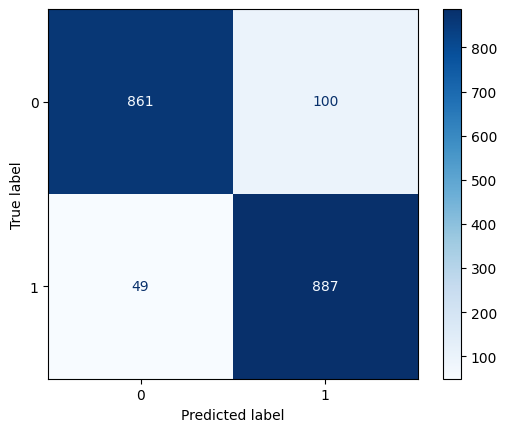

In [407]:
print(f"TfidfVectorizer and LogisticRegression")
c_matrix(pipe_tvec_log, X_test)
display_matrix(pipe_tvec_log, X_test, y_test)

Grid Search of TfidfVectorizer and LogisticRegression
Fitting 5 folds for each of 120 candidates, totalling 600 fits


C:\Users\skyne\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\skyne\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalt

Specificity: 0.8959417273673257
Sensitivity: 0.9487179487179487


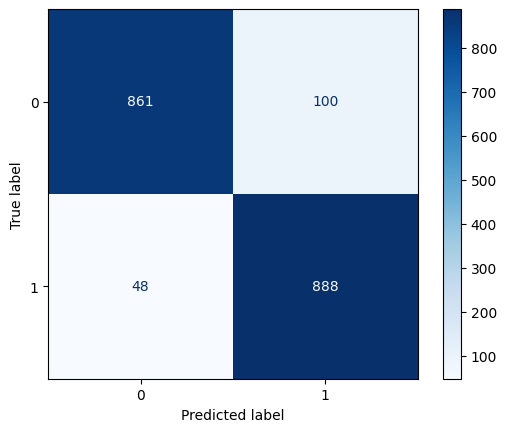

In [408]:
print("Grid Search of TfidfVectorizer and LogisticRegression")
c_matrix(gs_3, X_test)
display_matrix(gs_3, X_test, y_test)

TfidfVectorizer and MultinomialNB
Specificity: 0.9562955254942768
Sensitivity: 0.811965811965812


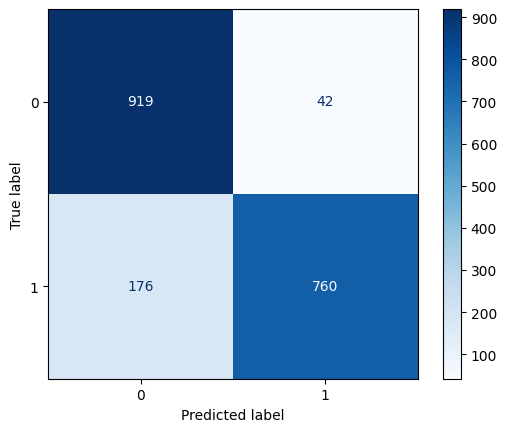

In [409]:
print(f"TfidfVectorizer and MultinomialNB")
c_matrix(pipe_tvec_nb, X_test)
display_matrix(pipe_tvec_nb, X_test, y_test)

Grid Search of TfidfVectorizer and MultinomialNB
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Specificity: 0.9177939646201873
Sensitivity: 0.8963675213675214


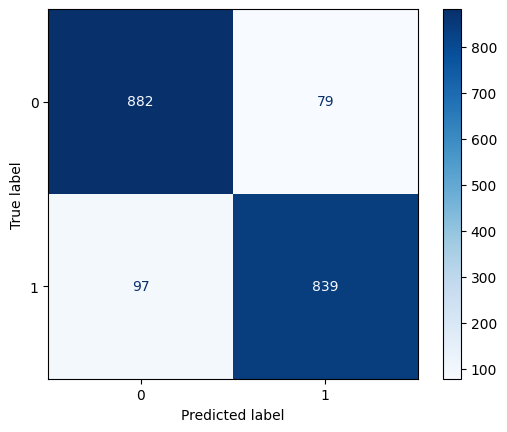

In [410]:
print("Grid Search of TfidfVectorizer and MultinomialNB")
c_matrix(gs_4, X_test)
display_matrix(gs_4, X_test, y_test)

In [411]:
#compare our model scores!
pd.DataFrame({
    'cvec + lr': [gs.score(X_train, y_train), gs.score(X_test, y_test), specificity],
    'tvec + lr': [gs_tv.score(X_train, y_train), gs.score(X_test, y_test), spec_tvec],
    'cvec + lr': [gs.score(X_train, y_train), gs.score(X_test, y_test), specificity],
    'tvec + lr': [gs_tv.score(X_train, y_train), gs.score(X_test, y_test), spec_tvec],
    'cvec + lr': [gs.score(X_train, y_train), gs.score(X_test, y_test), specificity],
    'tvec + lr': [gs_tv.score(X_train, y_train), gs.score(X_test, y_test), spec_tvec],
    'cvec + lr': [gs.score(X_train, y_train), gs.score(X_test, y_test), specificity],
    'tvec + lr': [gs_tv.score(X_train, y_train), gs.score(X_test, y_test), spec_tvec],
    
    
}, index = ['train acc', 'test acc', 'specificity'])

NameError: name 'specificity' is not defined

In [ ]:
fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)


plot_confusion_matrix(gs_rf, X_test, y_test, ax=ax1, cmap='Blues', values_format='d')
ax1.xaxis.set_ticklabels(['auto', 'tft']); ax1.yaxis.set_ticklabels(['auto', 'tft'])
ax1.set_title('RandomForest - GridSearchCV Confusion Matrix')

plot_confusion_matrix(best_nb, X_test, y_test, ax=ax2, cmap='Blues', values_format='d')
ax2.xaxis.set_ticklabels(['auto', 'tft']); ax2.yaxis.set_ticklabels(['auto', 'tft'])
ax2.set_title('NaiveBayes - Confusion Matrix')

plot_confusion_matrix(best_logr, X_test, y_test, ax=ax3, cmap='Blues', values_format='d')
ax3.xaxis.set_ticklabels(['auto', 'tft']); ax3.yaxis.set_ticklabels(['auto', 'tft'])
ax3.set_title('Logistic Regression - Confusion Matrix');

# plt.savefig("./images/confusion_matrix_evaluation.png", format="png")

#### Make a function to show scores

In [51]:
# from class
def model_score(classifier, X, y):
    """fit and score a model - print and return accuracy and predict_proba
    
    Args:
        classifier: an instance of a scikit-learn classification estimator
        X (2d pd.DataFrame or np.ndarray): features 
        y (1d pd.Series on np.ndarry): outcome variable
    
    Returns: 
        accuracy score (float): accuracy on the X_test
        predict_proba (array of floats): predicted probabilities for each class for each sample
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    proba = np.round(classifier.predict_proba(X_test),2)
    return f"score: {score}\nproba: {proba}"
